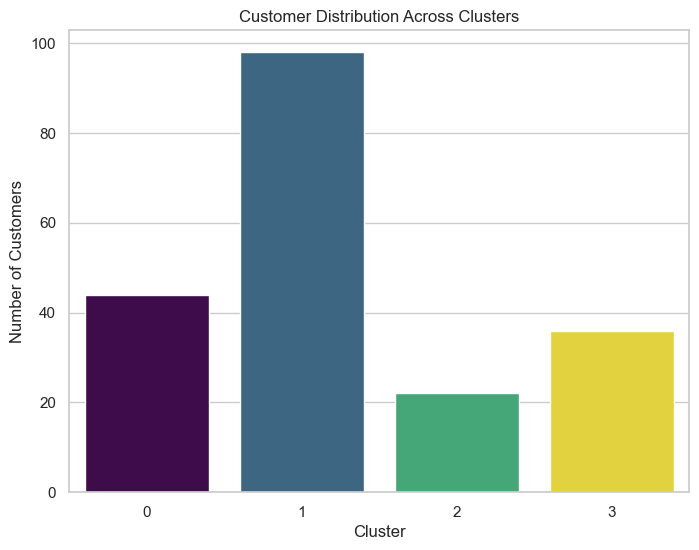

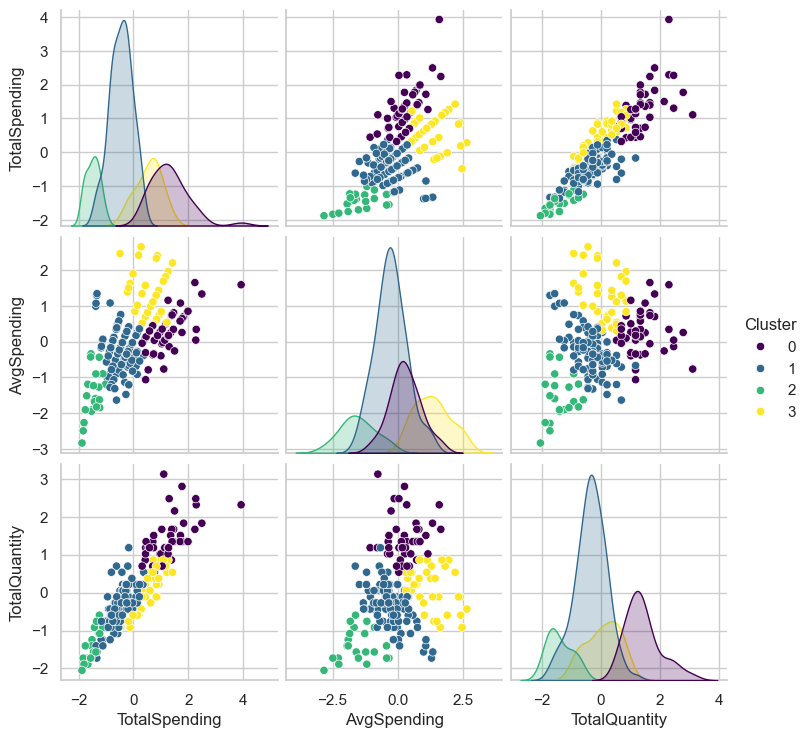

Number of clusters: 4
Davies-Bouldin Index: 1.210
Silhouette Score: 0.272


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')

# Step 2: Merge datasets and aggregate customer-level data
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'Quantity': 'sum'
}).reset_index()
customer_transactions.columns = ['CustomerID', 'TotalSpending', 'AvgSpending', 'TotalQuantity']

customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Step 3: Preprocess data (Encoding regions and standardizing numerical features)
customer_data_encoded = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

numerical_features = ['TotalSpending', 'AvgSpending', 'TotalQuantity']
scaler = StandardScaler()
customer_data_encoded[numerical_features] = scaler.fit_transform(customer_data_encoded[numerical_features])

# Step 4: Apply KMeans clustering
num_clusters = 4  # Chosen between 2 and 10 based on experimentation
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data_encoded['Cluster'] = kmeans.fit_predict(customer_data_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Step 5: Calculate clustering metrics
db_index = davies_bouldin_score(customer_data_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate', 'Cluster']), customer_data_encoded['Cluster'])
silhouette_avg = silhouette_score(customer_data_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate', 'Cluster']), customer_data_encoded['Cluster'])

# Step 6: Visualize the clusters (pairplot and cluster distribution)
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=customer_data_encoded, x='Cluster', hue='Cluster', palette='viridis', dodge=False)
plt.title('Customer Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend([], [], frameon=False)  # Optional: Removes redundant legend
plt.show()

# Pairplot to visualize clusters across features
cluster_visualization_data = customer_data_encoded[['TotalSpending', 'AvgSpending', 'TotalQuantity', 'Cluster']]
sns.pairplot(cluster_visualization_data, hue='Cluster', palette='viridis', diag_kind='kde')
plt.show()

# Step 7: Save the clustering results
customer_data_encoded.to_csv('Customer_Clusters.csv', index=False)

# Output results
print(f"Number of clusters: {num_clusters}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")
